In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
smuggle scipy as sp               # pip: scipy==1.10.1
smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from tqdm smuggle tqdm            # pip: tqdm==4.64.1

from sklearn.decomposition smuggle IncrementalPCA as PCA  # pip: scikit-learn==1.2.1

import os

from helpers import group_pca, cross_validation, plot_accuracy

In [3]:
basedir = os.path.split(os.path.split(os.getcwd())[0])[0]
datadir = os.path.join(basedir, 'data')
figdir = os.path.join(basedir, 'paper', 'figs', 'source')

# Creating synthetic datasets

We create four datasets, exemplifying each of the following scenarios:
  - High informativeness, high compressibility
  - High informativeness, low compressibility
  - Low informativeness, high compressibility
  - Low informativeness, low compressibility

The next cell doesn't actually make sense...maybe use the timecorr synthetic data generator?

Potential idea:
  - Create a multi-subject dataset
  - High informativeness = strong correlations across subjects, each timepoint has a unique pattern
  - High compressibility = highly similar features (e.g., all constant values)

In [70]:
S = 10
N = 250
K = 30

X = 25   # temporal scaling factor: increase for greater differentiation 
         # between high vs. low informativeness.
         # should divide into N evenly

Y = 10  # feature scaling factor: increase for greater differentiation 
        # between high vs. low compressibility.
        # should divide into K evenly


timepoint_unique = np.tile(np.atleast_2d(np.arange(N)).T, (1, K)) + 1
timepoint_shared = np.tile(np.atleast_2d(np.repeat(np.arange(N / X), X)).T, (1, K)) + 1

feature_unique = np.tile(np.atleast_2d(np.arange(K)), (N, 1)) + 1
feature_shared = np.tile(np.atleast_2d(np.repeat(np.arange(K / Y), Y)), (N, 1)) + 1

# generate template data
templates = {}
templates['HI_HC'] = timepoint_unique * feature_shared
templates['HI_LC'] = timepoint_unique * feature_unique
templates['LI_HC'] = timepoint_shared * feature_shared
templates['LI_LC'] = timepoint_shared * feature_unique

# generate subject data
noise = 100
data = {}
data['HI_HC'] = [templates['HI_HC'] + noise * np.random.normal(0, 1, (N, K)) for _ in range(S)]
data['HI_LC'] = [templates['HI_LC'] + noise * np.random.normal(0, 1, (N, K)) for _ in range(S)]
data['LI_HC'] = [templates['LI_HC'] + noise * np.random.normal(0, 1, (N, K)) for _ in range(S)]
data['LI_LC'] = [templates['LI_LC'] + noise * np.random.normal(0, 1, (N, K)) for _ in range(S)]

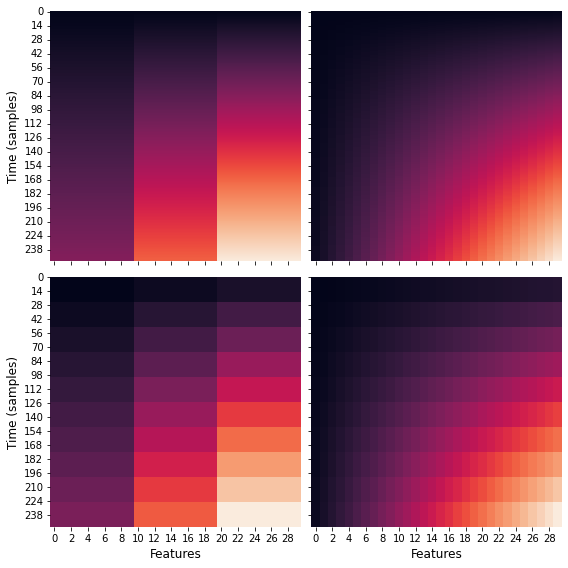

In [71]:
# plot some samples

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axs = axs.ravel()

sns.heatmap(templates['HI_HC'], ax=axs[0], cbar=False)
axs[0].set_ylabel('Time (samples)', fontsize=12)

sns.heatmap(templates['HI_LC'], ax=axs[1], cbar=False)

sns.heatmap(templates['LI_HC'], ax=axs[2], cbar=False)
axs[2].set_ylabel('Time (samples)', fontsize=12)
axs[2].set_xlabel('Features', fontsize=12)

sns.heatmap(templates['LI_LC'], ax=axs[3], cbar=False)
axs[3].set_xlabel('Features', fontsize=12)

fig.tight_layout()
fig.savefig(os.path.join(figdir, 'synthetic_data_templates.pdf'), bbox_inches='tight')


In [72]:
reduced_data = {k: {} for k in data.keys()}
max_components = K

for c in data.keys():
    for n in tqdm(range(3, max_components + 1)):
        fname = None #os.path.join(scratch_dir, f'pca_full_{c}_{n}.pkl')
        reduced_data[c][n], _ = group_pca(data[c], n_components=n, fname=fname)    

100%|██████████| 28/28 [00:00<00:00, 74.26it/s]


In [73]:
n_iter = 100

decoding_results = {k: {} for k in data.keys()}

for c in data.keys():
    # full time range
    fname = None # os.path.join(scratch_dir, f'decoding_results_{n_iter}_full_{c}.pkl')
    decoding_results[c] = cross_validation(reduced_data[c], n_iter=n_iter, fname=fname, max_components=K)

100%|██████████| 100/100 [00:04<00:00, 21.53it/s]


In [74]:
synth_colors = {'HI_HC': '#1f77b4', 'HI_LC': '#ff7f0e', 'LI_HC': '#2ca02c', 'LI_LC': '#d62728'}

Note: this doesn't actually "work"...need to change how the dataset is made

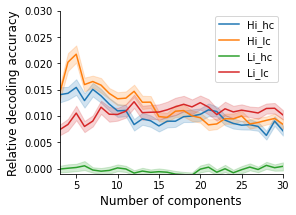

In [77]:
fig = plot_accuracy(decoding_results, conditions=['HI_HC', 'HI_LC', 'LI_HC', 'LI_LC'], condition_colors=synth_colors, xlim=[3, K], ylim=[-0.001, 0.03]);
plt.legend()